In [29]:
import sys
sys.path.insert(0,'/home/pawel1/Pulpit/Astrophysics/CTA/soft/ctapipe_io_lst')
sys.path.insert(0, '/home/pawel1/Pulpit/Astrophysics/CTA/cta-lstchain')

import matplotlib.pyplot as plt
import numpy as np
import h5py
from numba import njit, prange

from ctapipe_io_lst import LSTEventSource
from traitlets.config.loader import Config 
from ctapipe.image.extractor import LocalPeakWindowSum

from lstchain.calib.camera.r0 import LSTR0Corrections

from tools import get_first_capacitor
from time_cal_corr_all_camera import TimeCalCorr
from time_cal_corr import plot_corr_curve
plt.rcParams['font.size'] = 25

In [2]:
n_combine = 8
n_harm = 16
n_cap = 1024
n = int(n_cap/n_combine)
timeCorr = TimeCalCorr(n_combine, n_harm, n_cap)

config_corr = Config({
    "LSTR0Corrections": {
        "pedestal_path": "/media/pawel1/ADATA HD330/20190215/pedestal_run97_new.fits",
        "offset":  400,
        "tel_id": 0, # for EVB3 will be 
    }
})

#input_file_1 = "/media/pawel1/ADATA HD330/20190226/LST-1.*.Run00171.0000.fits.fz"
input_file_1 = "/media/pawel1/ADATA HD330/20190312/LST-1.*.Run00250.0000.fits.fz"

In [3]:
reader = LSTEventSource(input_url=input_file_1, max_events=20000)
lst_r0 = LSTR0Corrections(config=config_corr)

timeCorr = TimeCalCorr(n_combine, n_harm, n_cap)


for i, ev in enumerate(reader):
    if ev.r0.event_id%500 == 0:
        print(ev.r0.event_id)
    lst_r0.calibrate(ev)
    timeCorr.calib_pulse_time(ev)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000


In [4]:
timeCorr.finalize()

/home/pawel1/Pulpit/Astrophysics/CTA/low_level_calib_drs4/time_corr/time_cal_corr_all_camera.py:36: RuntimeWarning: divide by zero encountered in true_divide
  self.fMeanVal = self.fMeanVal /self.fNumMean
/home/pawel1/Pulpit/Astrophysics/CTA/low_level_calib_drs4/time_corr/time_cal_corr_all_camera.py:36: RuntimeWarning: invalid value encountered in true_divide
  self.fMeanVal = self.fMeanVal /self.fNumMean


In [5]:
fan_array = np.zeros((1855, n_harm))
fbn_array = np.zeros((1855, n_harm))
for pix_id in range(0, 1855):
    timeCorr.fit(pix_id)
    fan_array[pix_id, :] = timeCorr.fan
    fbn_array[pix_id, :] = timeCorr.fbn

In [ ]:
try:
    hf = h5py.File('coeff_run250_n_harm_16.h5', 'w')
    hf.create_dataset('fan', data=fan_array)
    hf.create_dataset('fbn', data=fbn_array)
    hf.attrs['n_harm'] = 16
except Exception as err:
    print("FAILED!", err)

hf.close()

In [ ]:
for pix_id in range(0, 5):
    print(pix_id)
    pixel_id = pix_id
    timeCorr.fit(pix_id)
    an = timeCorr.fan
    bn = timeCorr.fbn
    fMeanVal = timeCorr.fMeanVal[pix_id]
    plot_corr_curve(n, n_cap, n_combine, an, bn, fMeanVal)
    plt.show()

In [ ]:
for pix_id in range(0, 5):
    print(pix_id)
    pixel_id = pix_id
    timeCorr.fit(pix_id)
    an = timeCorr.fan
    bn = timeCorr.fbn
    fMeanVal = timeCorr.fMeanVal[pix_id]
    plot_corr_curve2(n, n_cap, n_combine, an, bn, fMeanVal)
    #if pix_id == 23:
        #plt.savefig("fit_curve_pixel22.png")
    plt.show()

In [ ]:
def plot_corr_curve2(n, n_cap, n_combine, an, bn, fMeanVal):
    fc = np.arange(0, n_cap, n_combine)
    y = np.zeros(n)

    for i in range(0, len(y)):
        temp_cos = an[0] / 2
        temp_sin = 0
        for j in range(1, len(an)):
            temp_cos += an[j] * np.cos(2 * j * np.pi * (fc[i] / n_cap))
            temp_sin += bn[j] * np.sin(2 * j * np.pi * (fc[i] / n_cap))
        y[i] = (temp_cos + temp_sin)

    fig, ax = plt.subplots(figsize=(16, 9))
    ax.plot(np.arange(0, n_cap, n_combine), fMeanVal, 'bo')
    ax.plot(fc, y, 'r--')
    ax.set_ylabel("Mean arrival time")
    ax.set_xlabel("Position in the DRS ring")

In [82]:
class FourieFit:
    def __init__(self, n_combine, n_harm, n_cap):
        self.fNumCombine = n_combine
        self.fNumHarmonics = n_harm
        self.fNumCap = n_cap
        self.fNumPoints = int(self.fNumCap/self.fNumCombine)
        self.n = int(n_cap/n_combine)
        
    def fit(self, fMeanVal):
        self.pos = np.zeros(self.fNumPoints)
        for i in range(0, self.fNumPoints):
            self.pos[i] = ( i +0.5 ) *self.fNumCombine

        self.fan = np.zeros(self.fNumHarmonics)
        self.fbn = np.zeros(self.fNumHarmonics)

        for n in range(0, self.fNumHarmonics):
            self.integrate_with_trig(self.pos, fMeanVal, n, self.fan, self.fbn)
        
        self.plot(fMeanVal, self.fan, self.fbn)
    
    def integrate_with_trig(self, x, y, n, an, bn):
        suma = 0
        sumb = 0

        for i in range(0, self.fNumPoints):
            suma += y[i] *self.fNumCombine *np.cos( 2 *np.pi * n *(x[i] /float(self.fNumCap)))
            sumb += y[i] *self.fNumCombine *np.sin( 2 *np.pi * n *(x[i] /float(self.fNumCap)))

        an[n] = suma *(2./(self.fNumPoints *self.fNumCombine))
        bn[n] = sumb *(2./(self.fNumPoints *self.fNumCombine))
        
    def plot(self, fMeanVal, an, bn):
        fc = np.arange(0, self.fNumCap, self.fNumCombine )
        y = np.zeros(self.n)

        for i in range(0, len(y)):
            temp_cos = an[0] / 2
            temp_sin = 0
            for j in range(1, len(an)):
                temp_cos += an[j] * np.cos(2 * j * np.pi * (fc[i] / self.fNumCap))
                temp_sin += bn[j] * np.sin(2 * j * np.pi * (fc[i] / self.fNumCap))
            y[i] = (temp_cos + temp_sin)

        #fig, ax = plt.subplots(figsize=(16, 9))
        plt.plot(fc, fMeanVal, 'bo', markersize=8, color="b")
        plt.plot(fc, y, 'r--', lw=4.)
        plt.ylabel("Średni czas przyjścia impulsu")
        plt.xlabel("Pozycja w pierścieniu DRS4")

In [83]:
n_combine = 8
n_harm = 16
n_cap = 1024
four_fit = FourieFit(n_combine, n_harm, n_cap)

In [ ]:
pix_id = 180
fMeanVal = timeCorr.fMeanVal[pix_id]
four_fit.fit(fMeanVal)
plt.grid(True)
#plt.savefig("/home/pawel1/Pulpit/Astrophysics/Praca Magisterska/wykresy/drs4/fourier_fit.pdf")

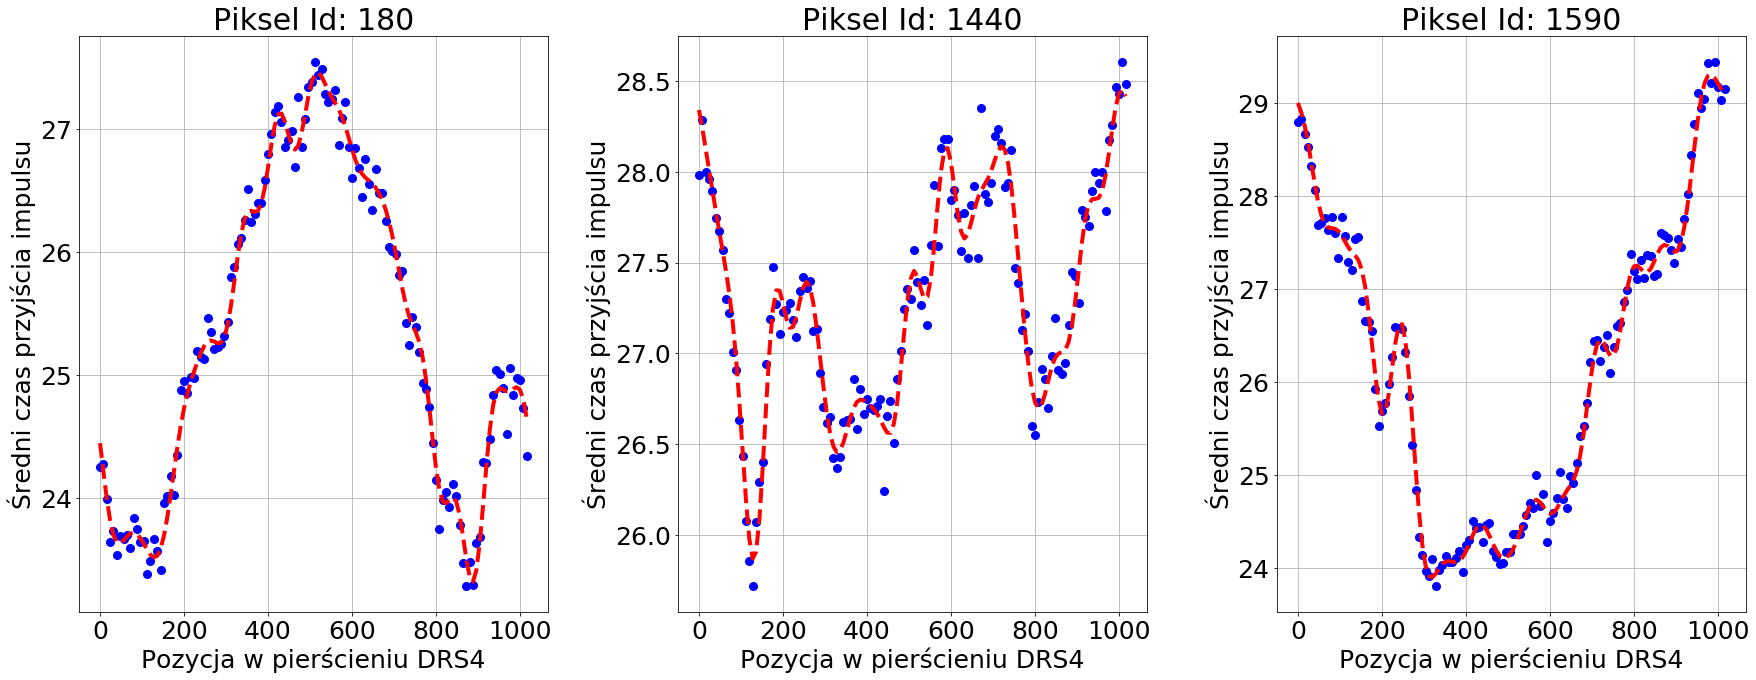

In [97]:

plt.figure(figsize=(25,10)) # 10 is width, 4 is height

# Left hand side plot
plt.subplot(1,3,1) 
fMeanVal = timeCorr.fMeanVal[180]
four_fit.fit(fMeanVal)
plt.grid(True)
plt.title("Piksel Id: 180")
#plt.ylim([20, 30])

plt.subplot(1,3,2) 
fMeanVal = timeCorr.fMeanVal[1440]
four_fit.fit(fMeanVal)
plt.grid(True)
plt.title("Piksel Id: 1440")
#plt.ylim([20, 30])

plt.subplot(1,3,3) 
fMeanVal = timeCorr.fMeanVal[1590]
four_fit.fit(fMeanVal)
plt.grid(True)
plt.title("Piksel Id: 1590")
#plt.ylim([20, 30])


plt.tight_layout()
plt.savefig("/home/pawel1/Pulpit/Astrophysics/Praca Magisterska/wykresy/drs4/fourier_fit_3pixels.pdf")


180


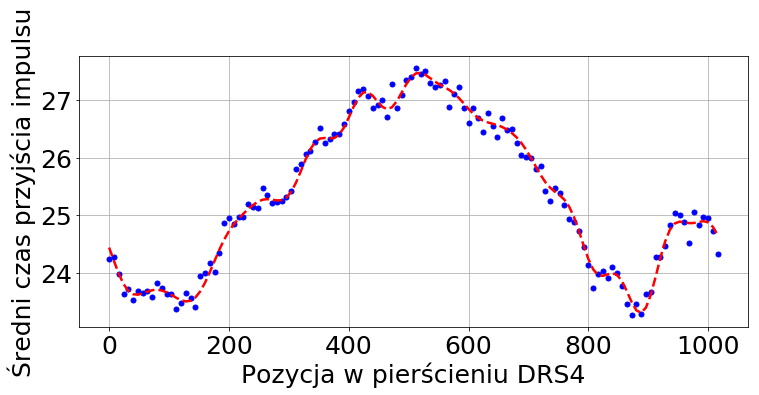

210


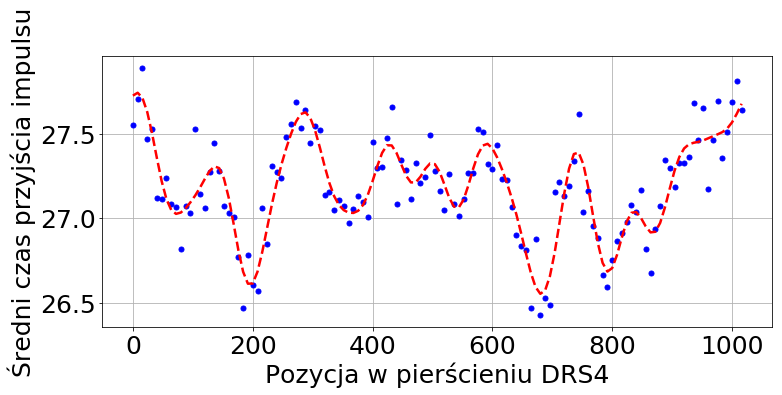

240


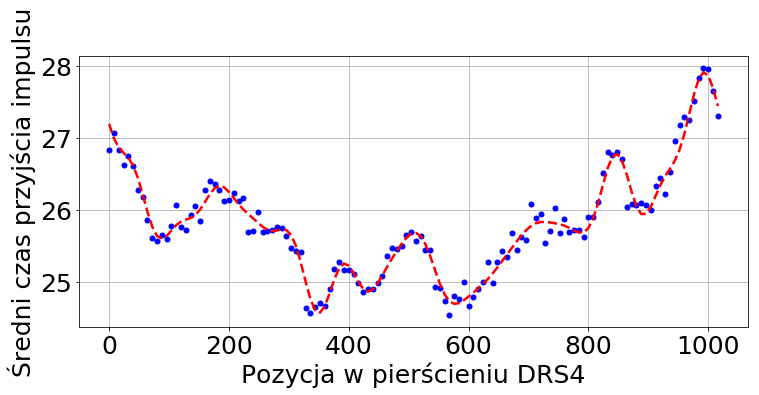

270


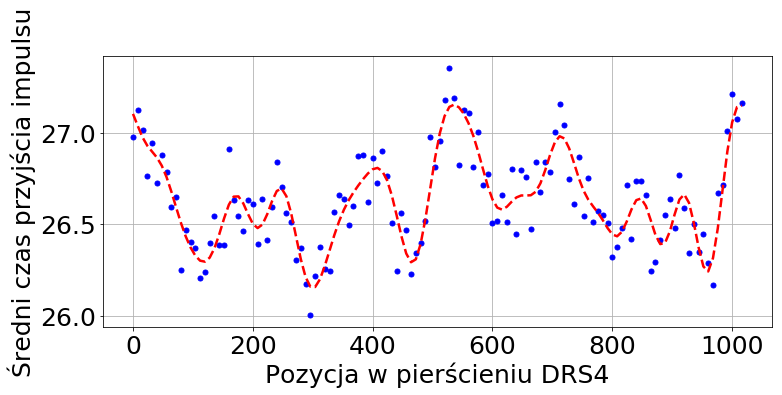

300


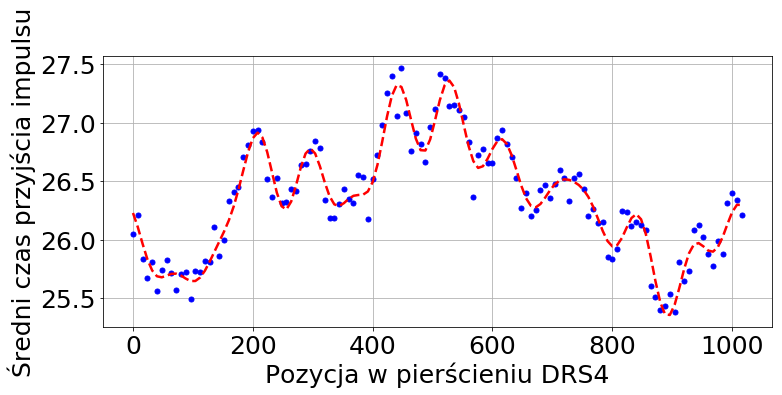

330


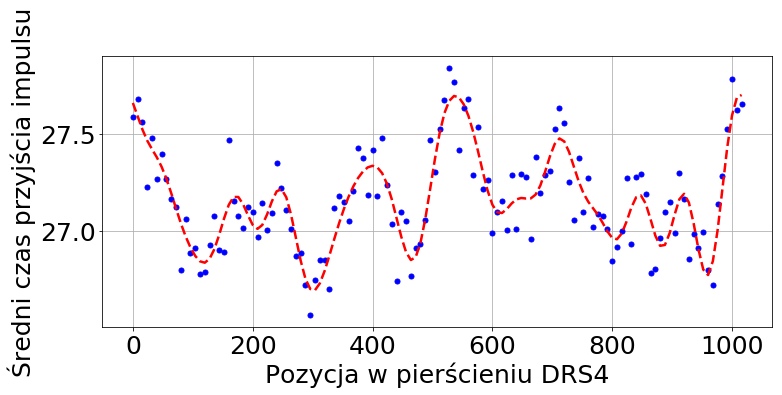

360


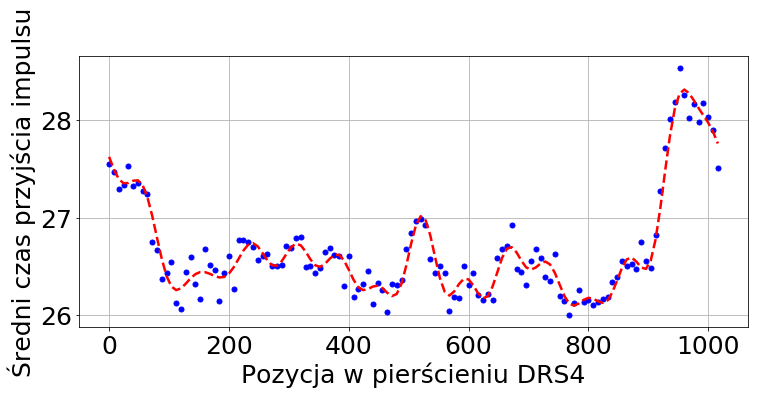

390


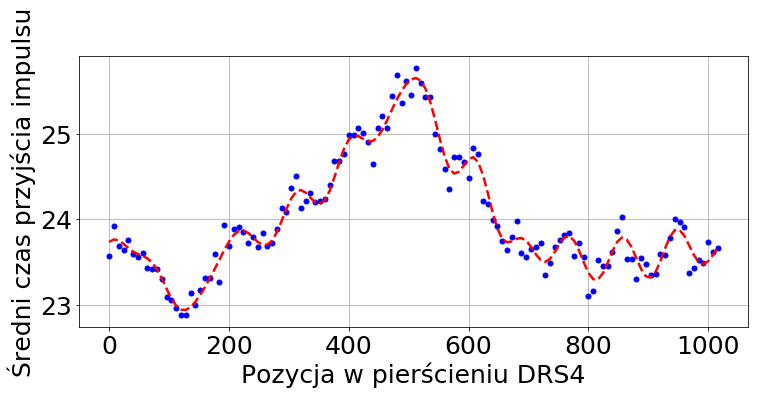

420


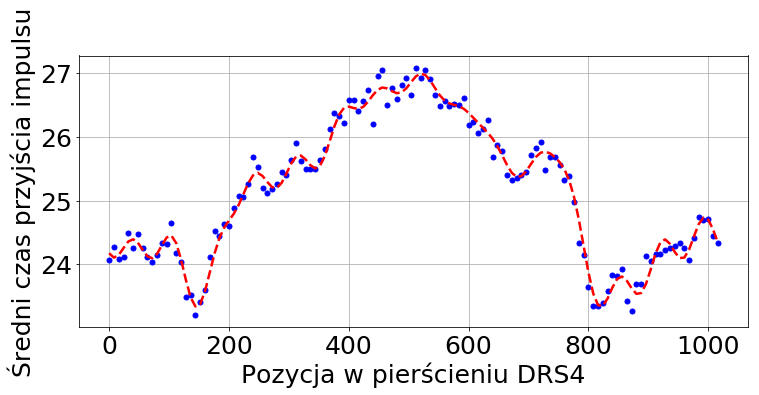

450


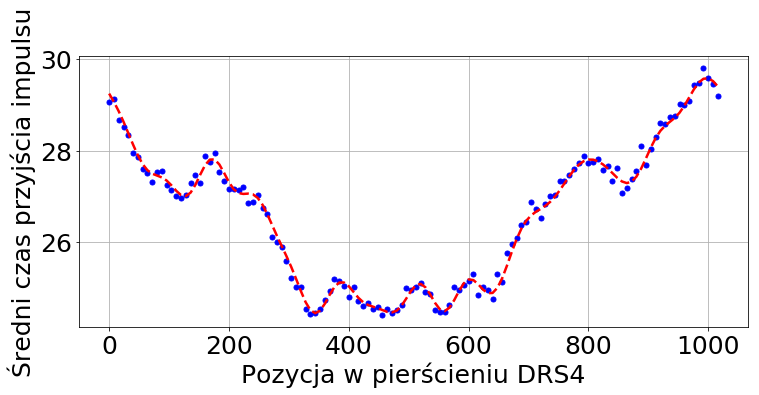

480


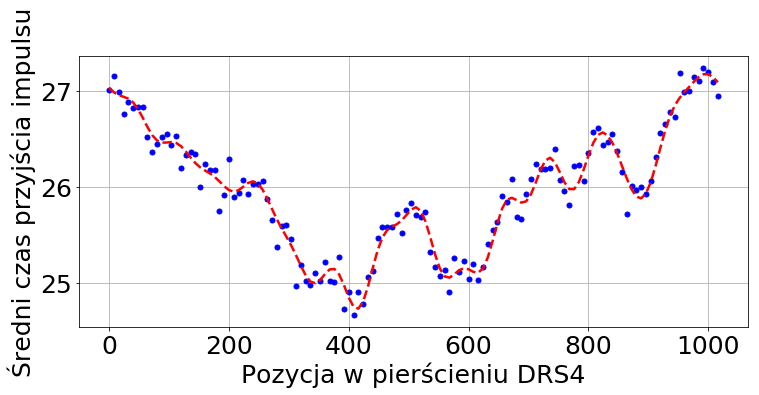

510


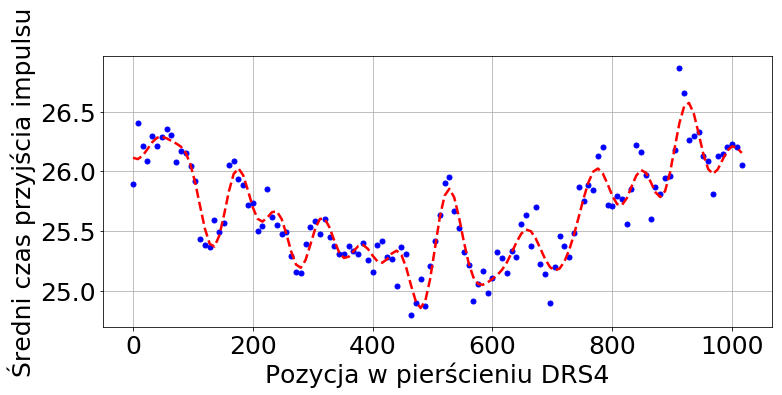

540


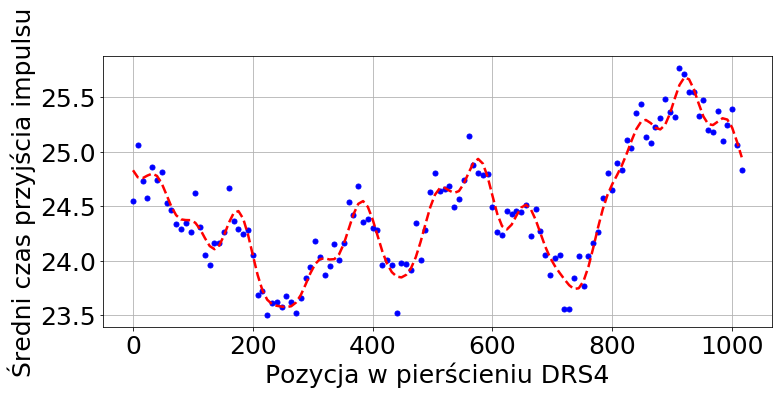

570


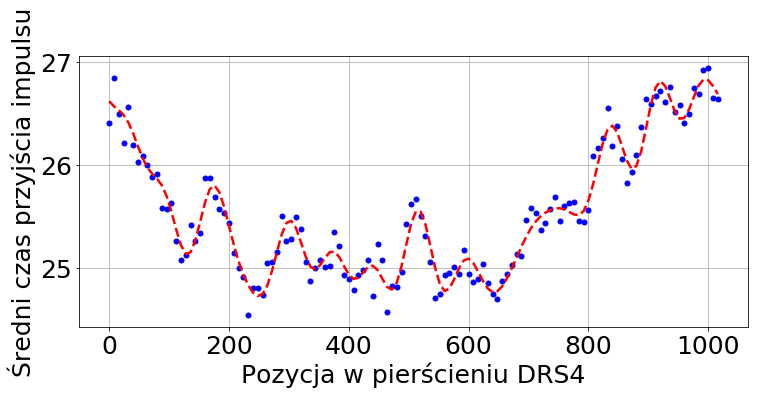

600


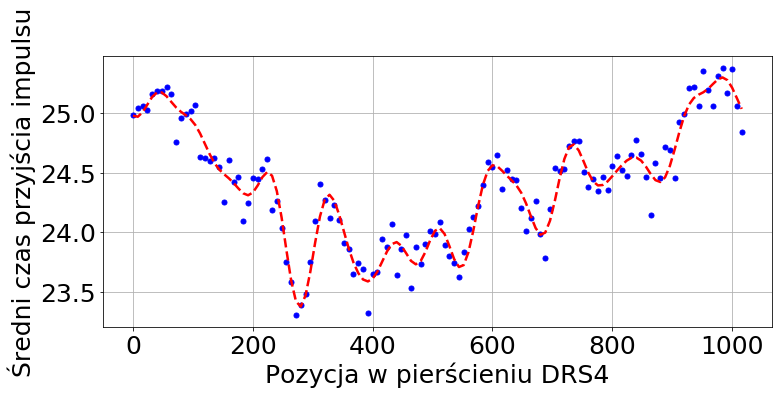

630


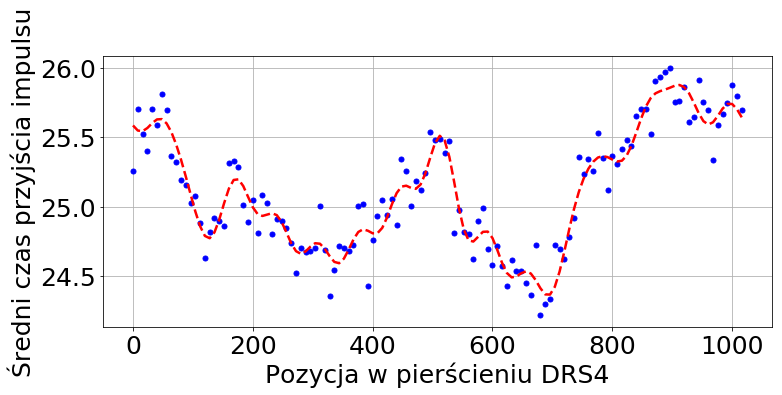

660


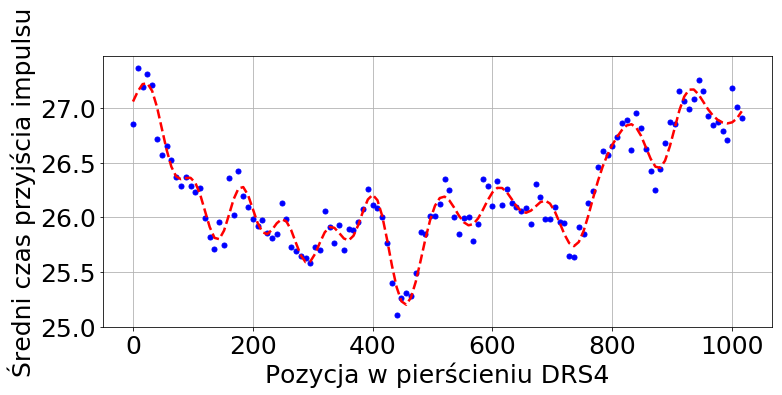

690


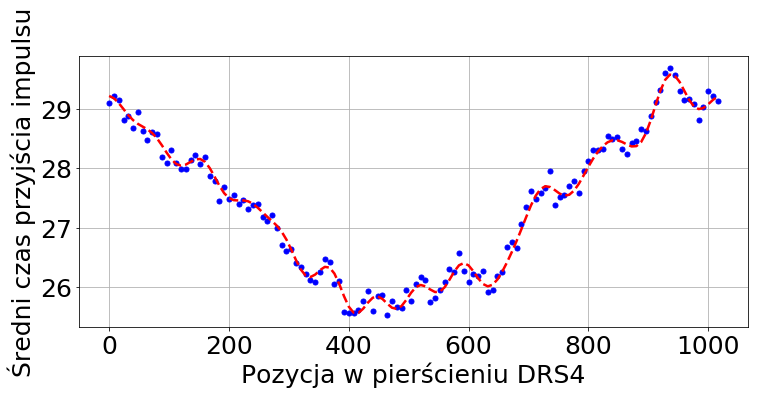

720


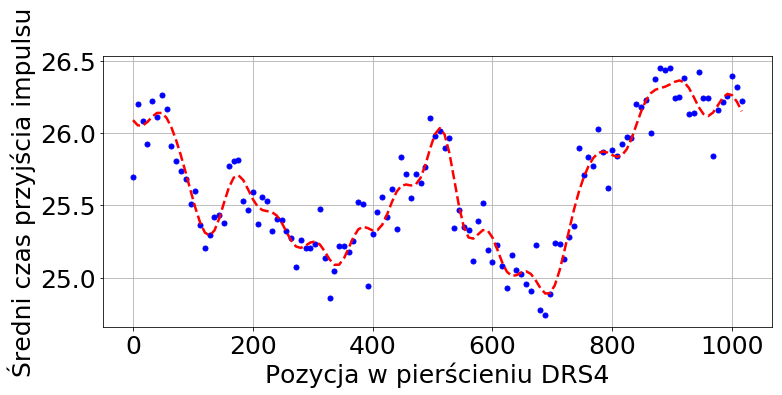

750


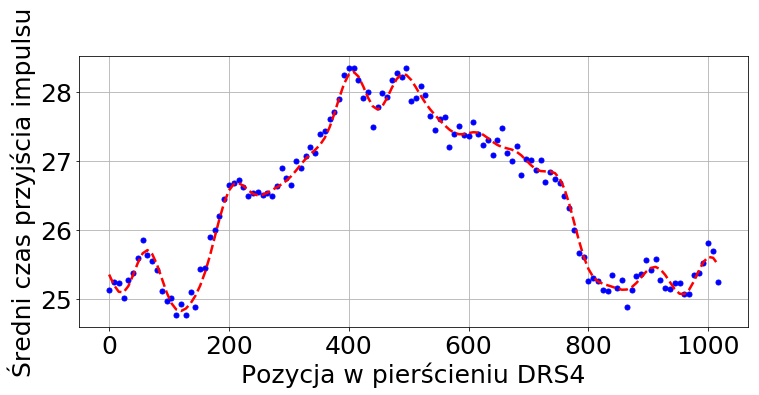

780


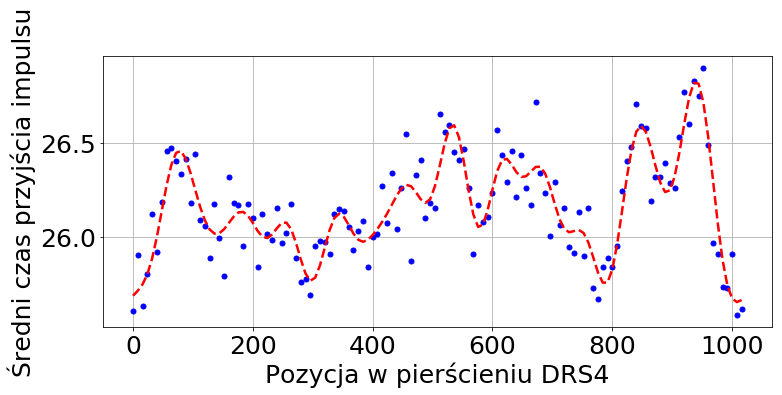

810


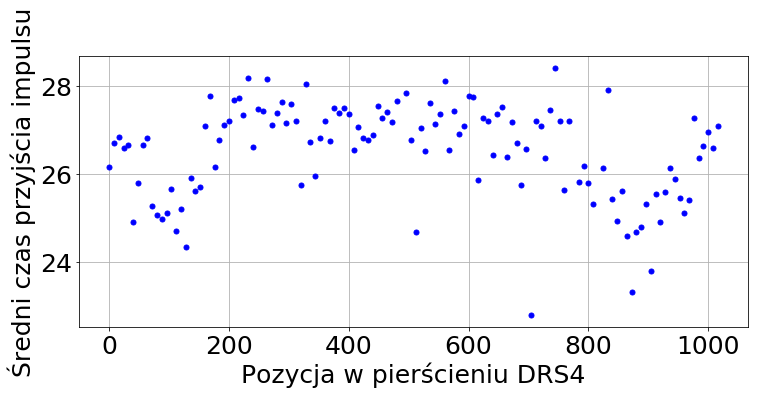

840


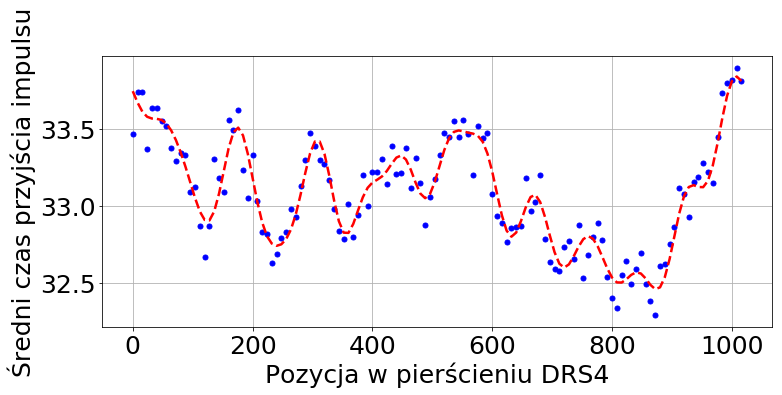

870


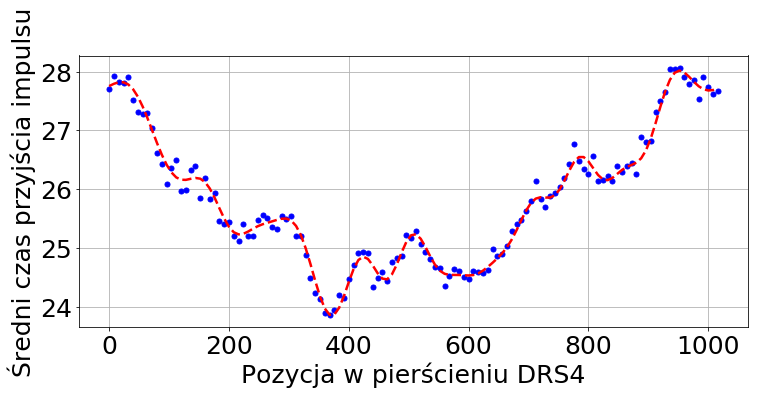

900


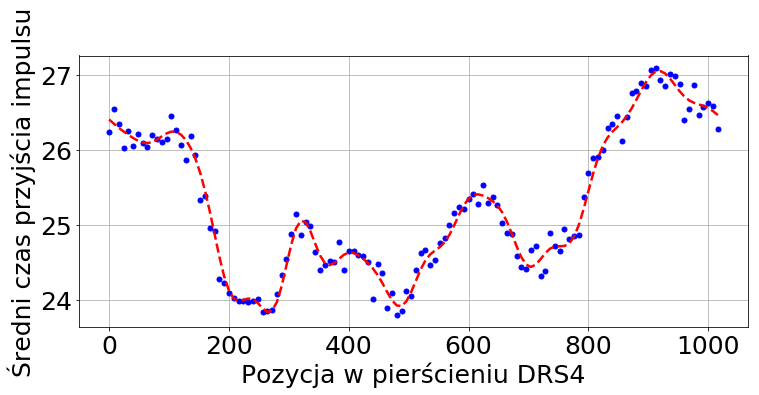

930


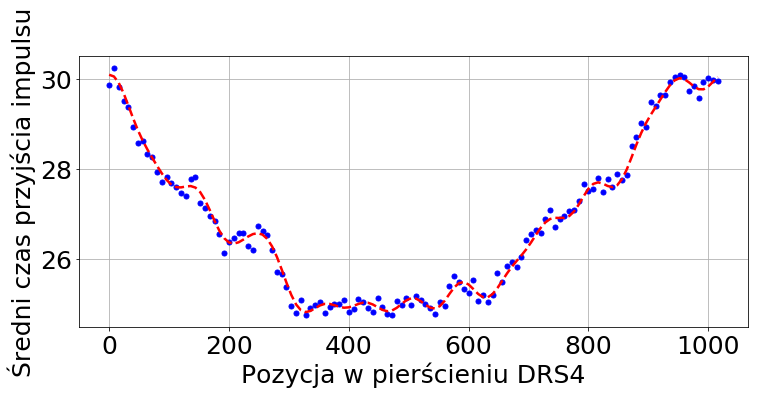

960


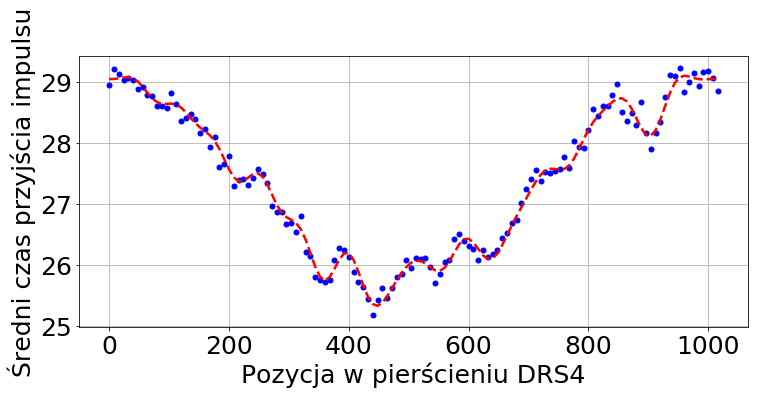

990


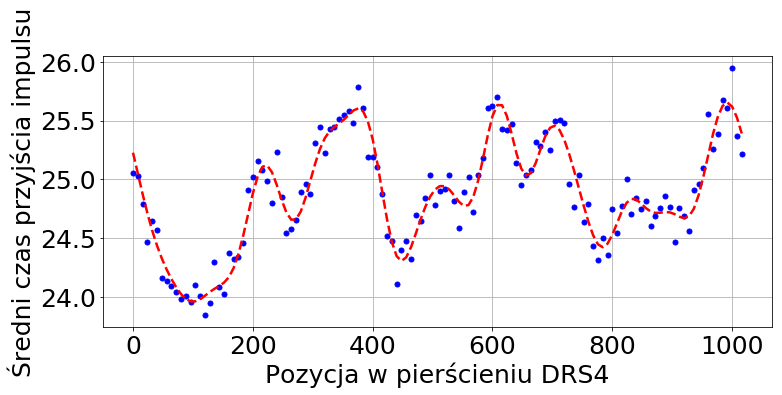

1020


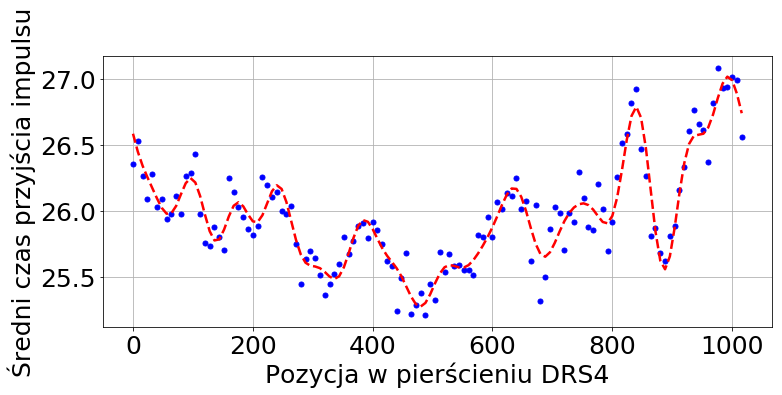

1050


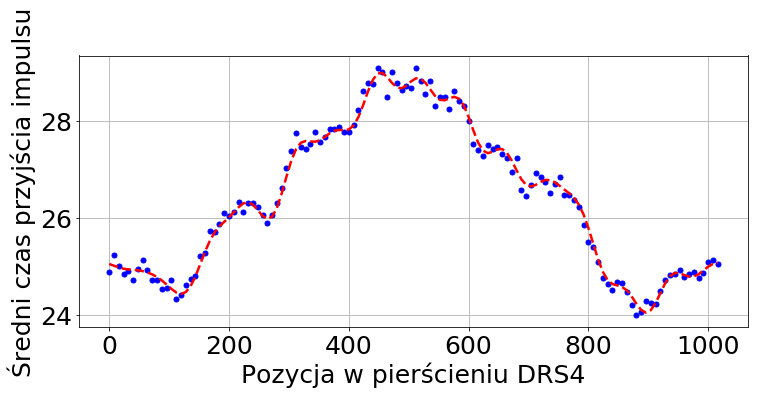

1080


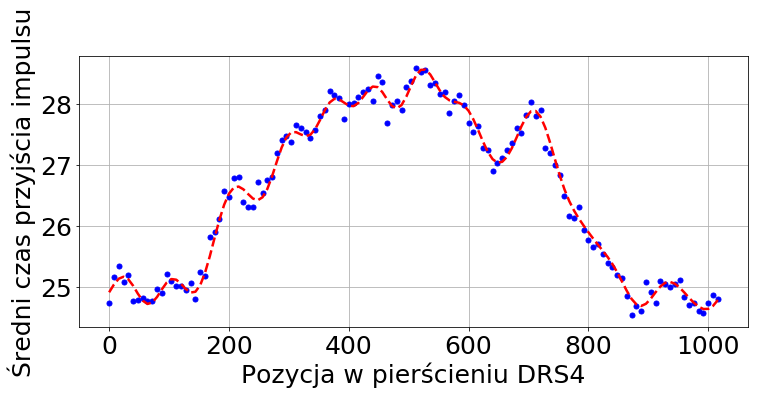

1110


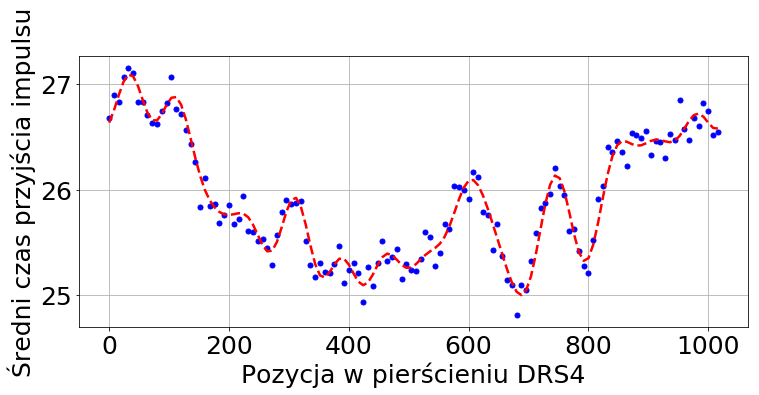

1140


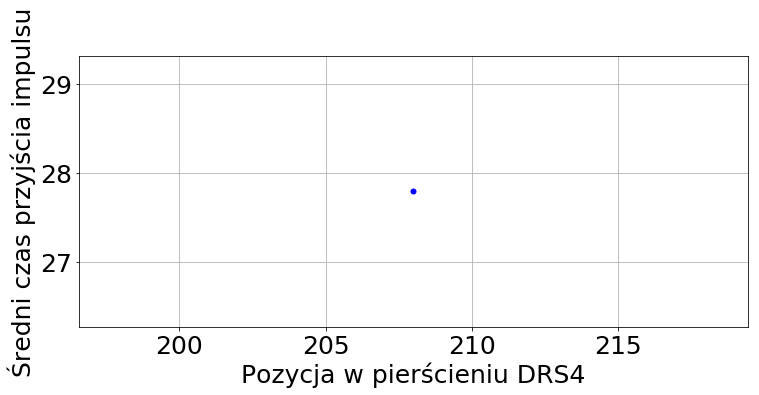

1170


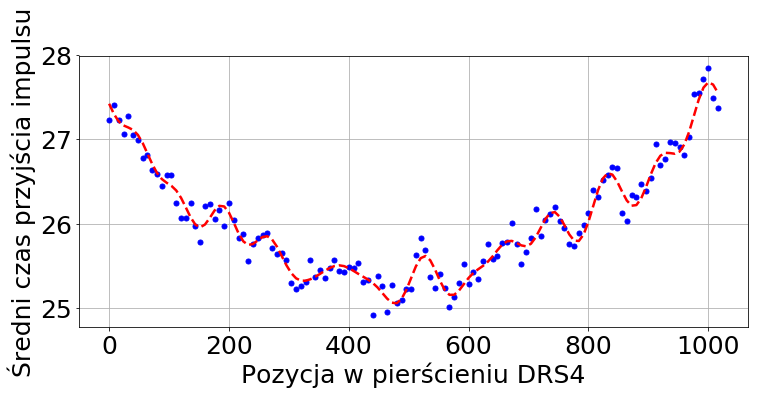

1200


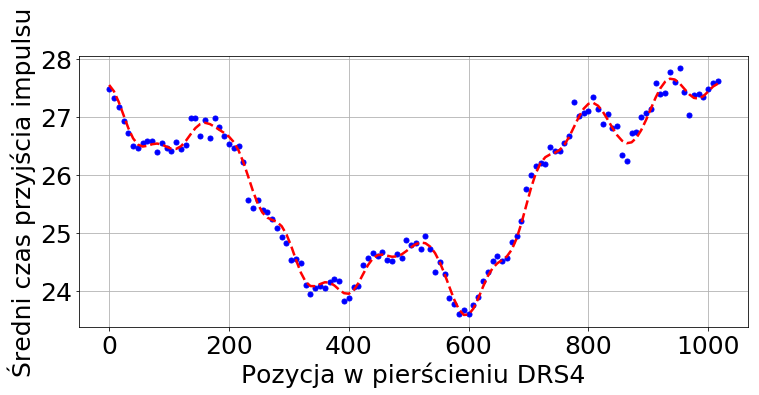

1230


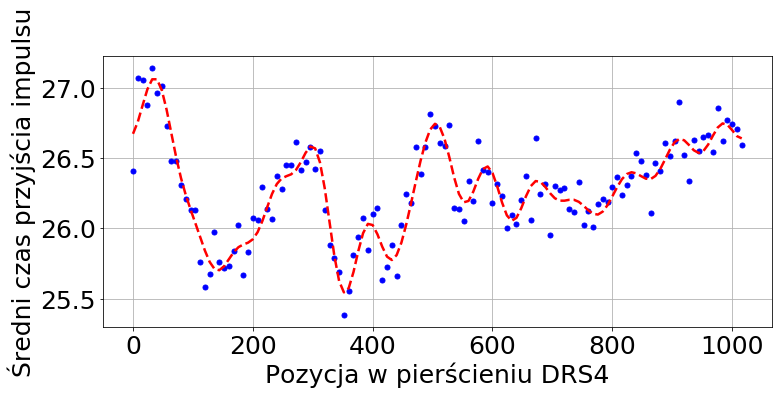

1260


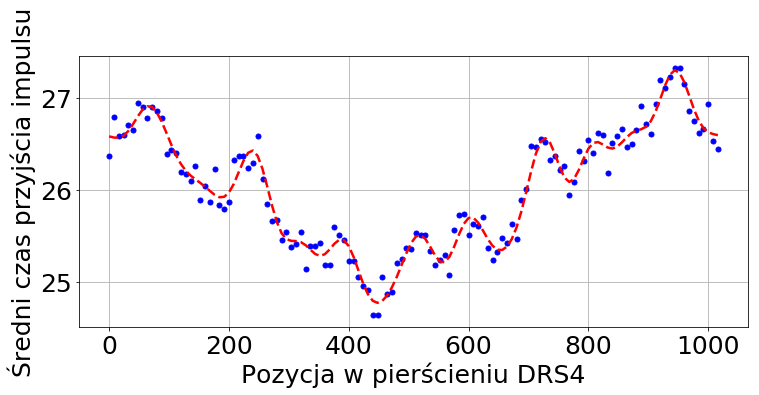

1290


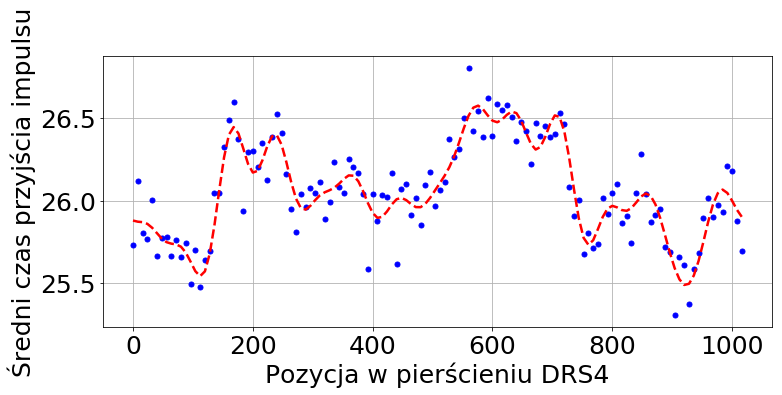

1320


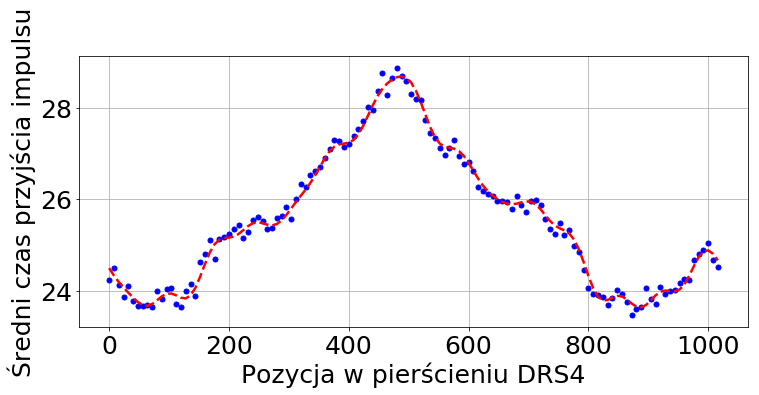

1350


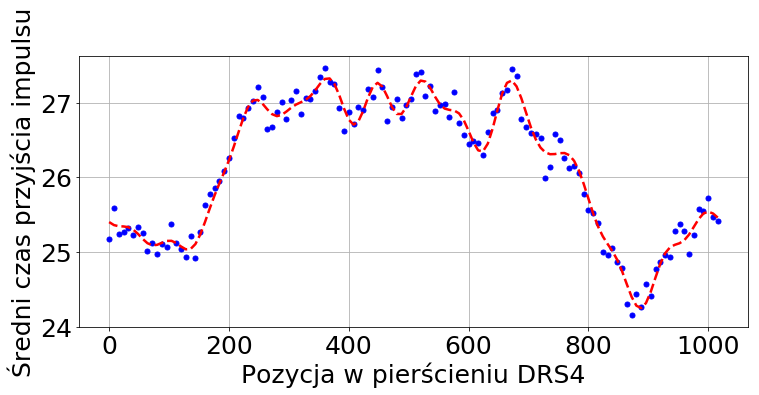

1380


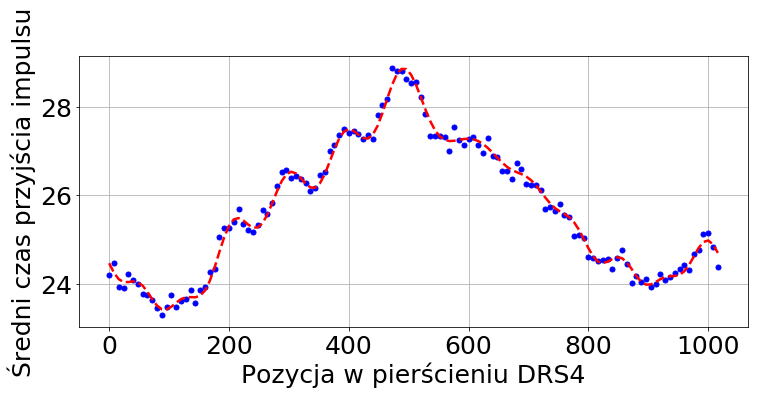

1410


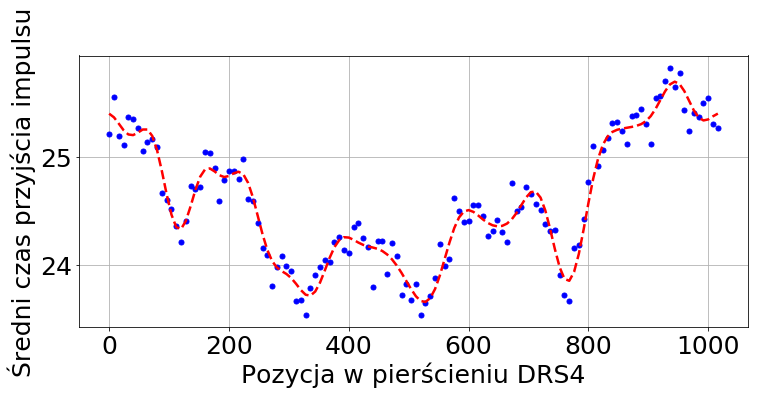

1440


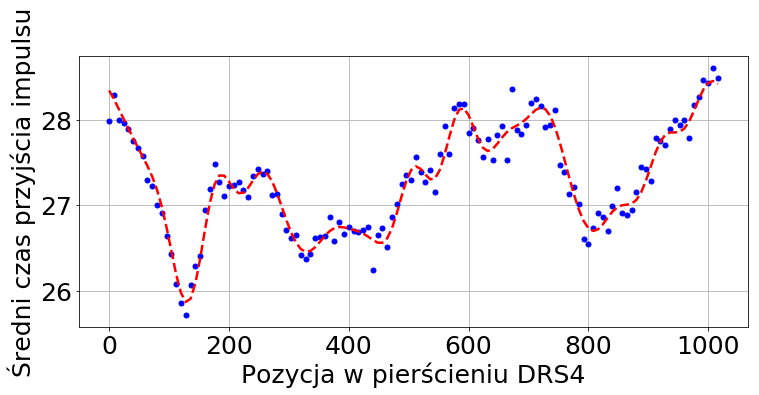

1470


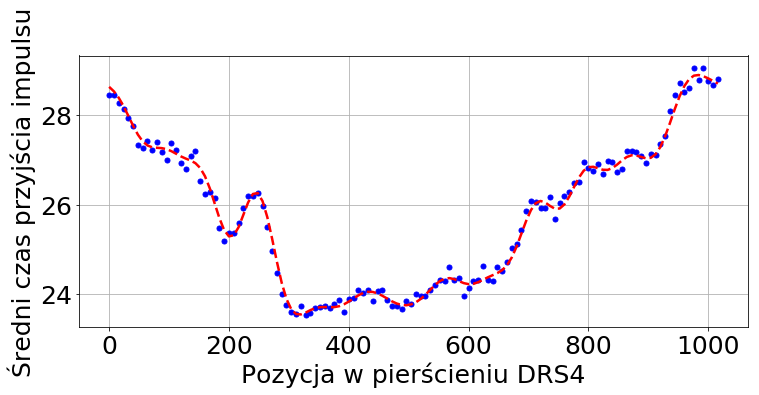

1500


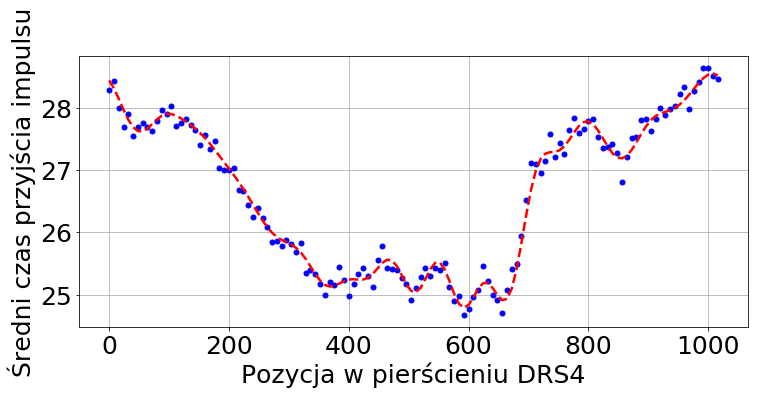

1530


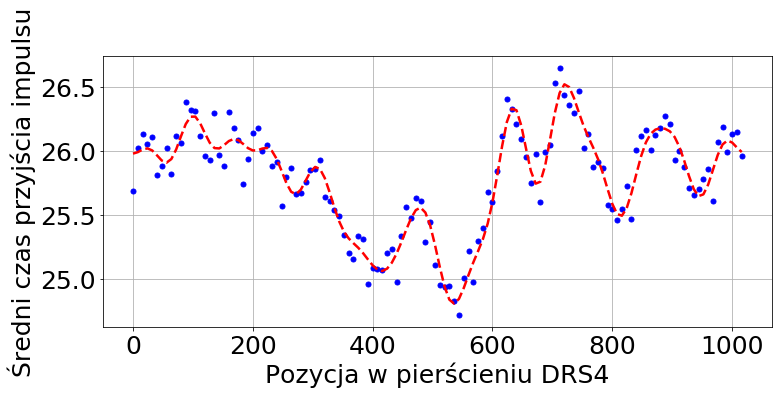

1560


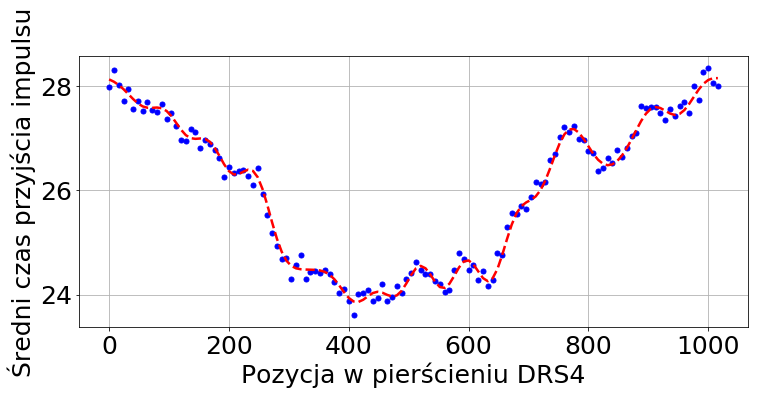

1590


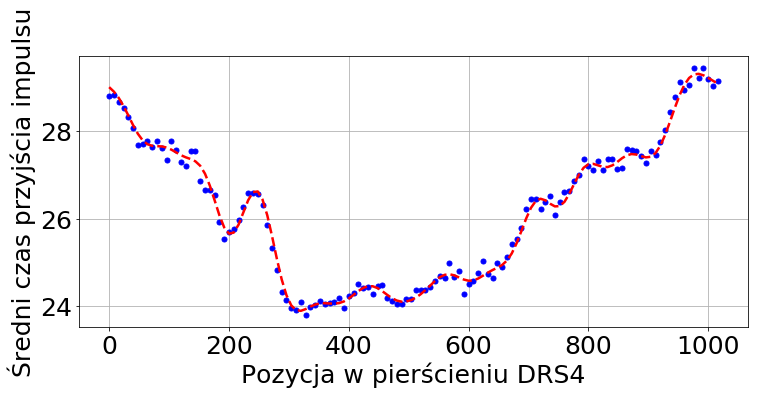

1620


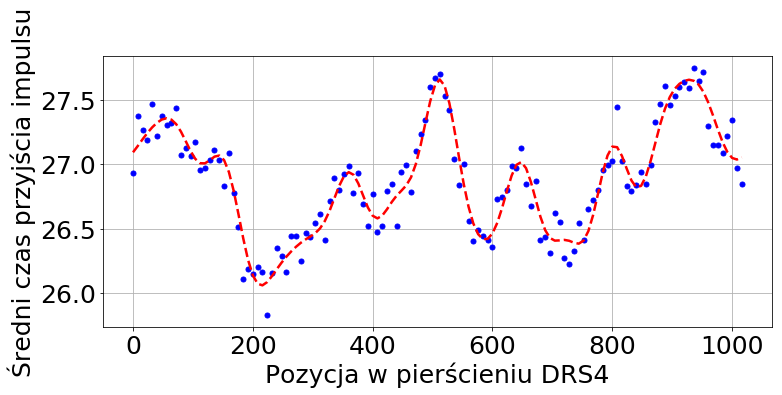

1650


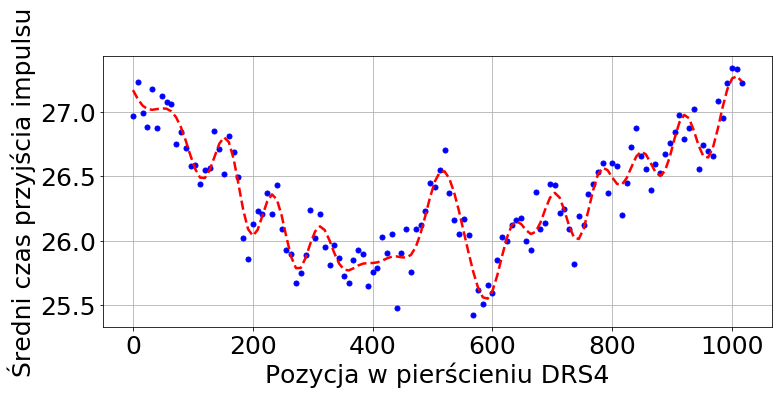

1680


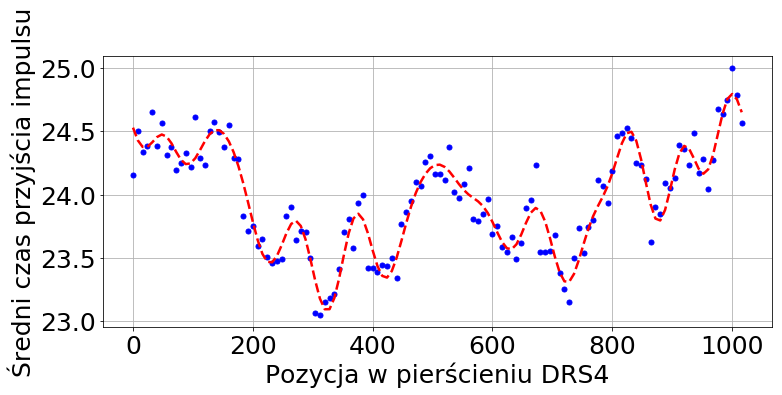

1710


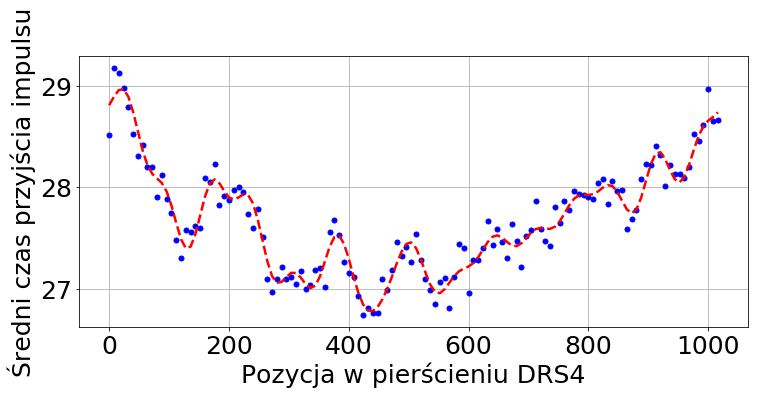

1740


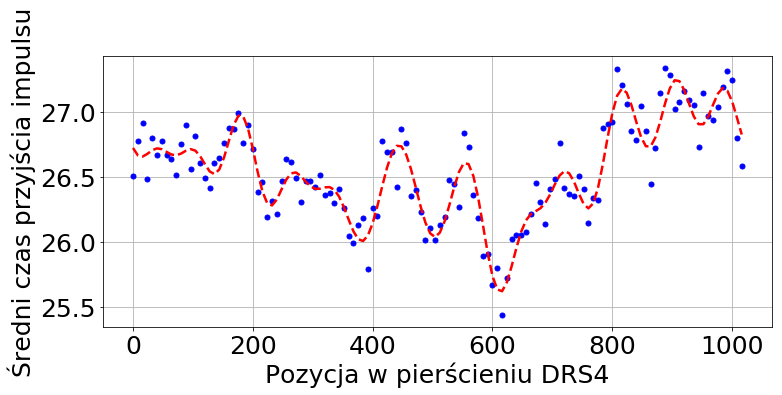

1770


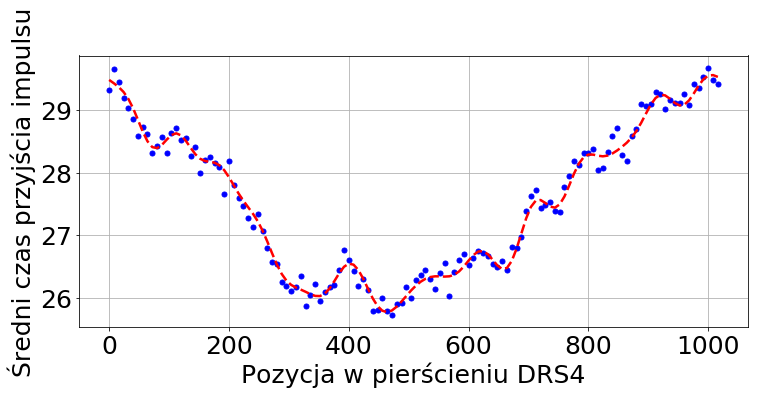

In [59]:
for pix_id in range(180, 1800, 30):
    print(pix_id)
    plt.figure(figsize=(12,5))
    fMeanVal = timeCorr.fMeanVal[pix_id]
    four_fit.fit(fMeanVal)
    plt.grid(True)
    plt.show()